# Comparaison des algorithmes d'ensemble 

Dans ce notebook nous comparons les differentes algorithmes d'ensemble "Adaboost", "XGBClassifier" et "Stacking"

In [1]:
!python ../lib/lib_install.py

In [2]:
# Import libraries and modules

# Import the necessary libraries
import sys
import os

# Add the project directory to the sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import everything from lib_import.py, data_exploring.py, data_preprocessing.py 
from lib.lib_import import *
from src.data_preprocessing import *
from src.model_evaluation import *
from src.model_training import *

# Import the data
from data.data_extract import load_data

Everything imported successfully.


In [3]:
# Load the data

df_data = load_data()
df_data.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


## Data Preprocessing

In [4]:
df = df_data.copy()
df = preprocess(df)
df.head(10)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,>50K
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp,83311,13,Married,Exec-managerial,Married,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Now Single,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married,Handlers-cleaners,Married,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married,Prof-specialty,Married,Black,Female,0,0,40,Other,0
5,37,Private,284582,14,Married,Exec-managerial,Married,White,Female,0,0,40,United-States,0
6,49,Private,160187,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Other,0
7,52,Self-emp,209642,9,Married,Exec-managerial,Married,White,Male,0,0,45,United-States,1
8,31,Private,45781,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,1
9,42,Private,159449,13,Married,Exec-managerial,Married,White,Male,5178,0,40,United-States,1


In [5]:
df.shape

(48544, 14)

In [6]:
df.duplicated().sum()

0

In [7]:
cat_features = get_cat_features(df)
cont_features = get_cont_features(df)


In [8]:
cont_features

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [9]:
cat_features

Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'sex', 'native-country', 'education-num'],
      dtype='object')

In [10]:
df_train, df_test = seperate_train_test(df, random_state=42)
df_train,df_test =impute_missing_cat_values(df_train, df_test,cat_features,strategy='most_frequent')
df_train,df_test = standardize(df_train, df_test, cont_features)
df_train,df_test = encode_cat_features_onehot(df_train, df_test, cat_features)

In [11]:
df_train.shape

(38835, 65)

In [12]:
df_test.shape

(9709, 65)

In [13]:
df_train_select = df_train.drop('>50K', axis=1)
df_test_select = df_test.drop('>50K', axis=1)
target_train = df_train['>50K']
target_test = df_test['>50K']

In [14]:
X_train = df_train_select.values
X_test = df_test_select.values

y_train = df_train['>50K'].values
y_test = df_test['>50K'].values


In [15]:
# Entraîner et évaluer Adaboost
from sklearn.metrics import precision_score, recall_score, roc_auc_score


adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(X_train, y_train)
y_pred_adaboost = adaboost_model.predict(X_test)
adaboost_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_adaboost),
    'Precision': precision_score(y_test, y_pred_adaboost),
    'Recall': recall_score(y_test, y_pred_adaboost),
    'F1 Score': f1_score(y_test, y_pred_adaboost),
    'AUC': roc_auc_score(y_test, adaboost_model.predict_proba(X_test)[:, 1])
}

In [16]:
adaboost_scores

{'Accuracy': 0.8633226902873622,
 'Precision': 0.764026402640264,
 'Recall': 0.6073458679492786,
 'F1 Score': 0.6767356881851401,
 'AUC': 0.9114680153556174}

In [17]:
# Entraîner et évaluer XGBClassifier
xgb_model1 = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model1.fit(X_train, y_train)
y_pred_xgb = xgb_model1.predict(X_test)
xgb_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb),
    'F1 Score': f1_score(y_test, y_pred_xgb),
    'AUC': roc_auc_score(y_test, xgb_model1.predict_proba(X_test)[:, 1])
}

In [18]:
# Entraîner et évaluer Stacking
from sklearn.ensemble import StackingClassifier


estimators = [
    ('adaboost', adaboost_model),
    ('xgb', xgb_model1)
]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
stacking_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_stacking),
    'Precision': precision_score(y_test, y_pred_stacking),
    'Recall': recall_score(y_test, y_pred_stacking),
    'F1 Score': f1_score(y_test, y_pred_stacking),
    'AUC': roc_auc_score(y_test, stacking_model.predict_proba(X_test)[:, 1])
}

In [19]:
# Afficher les résultats
print("Adaboost Scores:", adaboost_scores)
print("XGBClassifier Scores:", xgb_scores)
print("Stacking Score",stacking_scores )

Adaboost Scores: {'Accuracy': 0.8633226902873622, 'Precision': 0.764026402640264, 'Recall': 0.6073458679492786, 'F1 Score': 0.6767356881851401, 'AUC': 0.9114680153556174}
XGBClassifier Scores: {'Accuracy': 0.8677515707075909, 'Precision': 0.7718157181571815, 'Recall': 0.6226497595102755, 'F1 Score': 0.6892545982575025, 'AUC': 0.9206106427705152}
Stacking Score {'Accuracy': 0.8677515707075909, 'Precision': 0.7766133480419195, 'Recall': 0.6156536947966769, 'F1 Score': 0.6868292682926829, 'AUC': 0.9208353083996017}


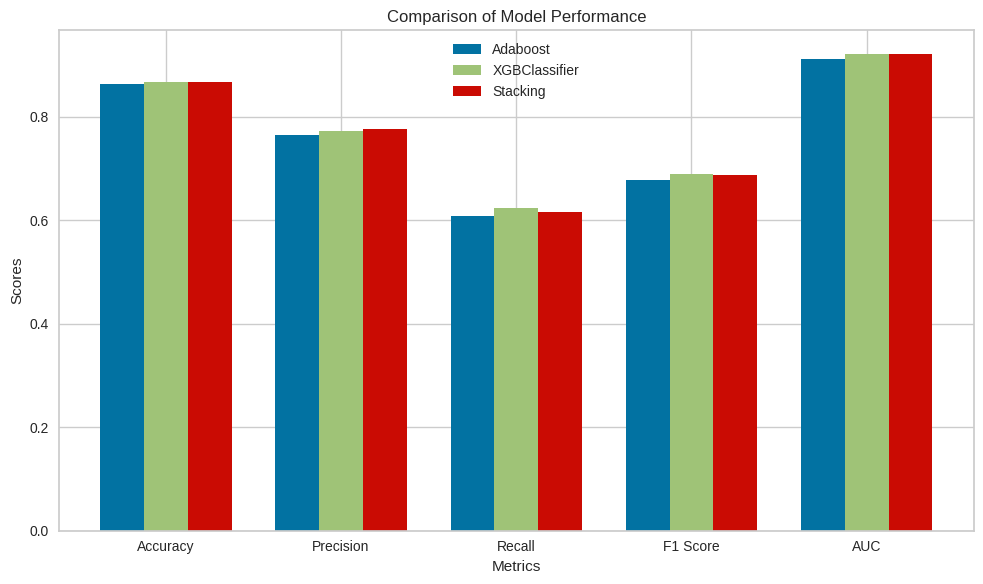

In [20]:
# Conversion des scores en listes pour l'affichage
categories = list(adaboost_scores.keys())
adaboost_values = list(adaboost_scores.values())
xgb_values = list(xgb_scores.values())
stacking_values = list(stacking_scores.values())

# Paramètres pour les barres
bar_width = 0.25
index = np.arange(len(categories))

# Création des barres
plt.figure(figsize=(10, 6))
bar1 = plt.bar(index, adaboost_values, bar_width, label='Adaboost')
bar2 = plt.bar(index + bar_width, xgb_values, bar_width, label='XGBClassifier')
bar3 = plt.bar(index + 2 * bar_width, stacking_values, bar_width, label='Stacking')

# Ajout des labels et titre
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks(index + bar_width, categories)
plt.legend()

# Affichage de l'histogramme
plt.tight_layout()
plt.show()

Nous remarquons que les performances de XGBClassifier est le meilleur, nous essayons dans le notebook "models_GradientBoosting" d'optimiser ses hyperparametres